In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from IPython.display import display, HTML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Loading Dataset

In [14]:
data = pd.read_csv('db_one_cleaned.csv') # aggregated large database

# Dataset Preprocessing

In [15]:
# Preprocess the dataset
data_encoded = data.copy()

# Convert datetime columns to numeric features (e.g., year, month)
if 'TIME_PERIOD_START' in data_encoded.columns:
    data_encoded['Start_Year'] = pd.to_datetime(data_encoded['TIME_PERIOD_START'], errors='coerce').dt.year
    data_encoded['Start_Month'] = pd.to_datetime(data_encoded['TIME_PERIOD_START'], errors='coerce').dt.month
if 'TIME_PERIOD_END' in data_encoded.columns:
    data_encoded['End_Year'] = pd.to_datetime(data_encoded['TIME_PERIOD_END'], errors='coerce').dt.year
    data_encoded['End_Month'] = pd.to_datetime(data_encoded['TIME_PERIOD_END'], errors='coerce').dt.month

# Drop original datetime columns
data_encoded = data_encoded.drop(columns=['TIME_PERIOD_START', 'TIME_PERIOD_END'], errors='ignore')

# Encoding Categorical Variables

In [16]:
# Encode categorical variables
label_encoders = {}
for column in data_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_encoded[column] = le.fit_transform(data_encoded[column])
    label_encoders[column] = le

# Defining Features

In [17]:
# Define features (X) and target (y)
X = data_encoded.drop(['PRIMARY_TYPE'], axis=1)  # Features: All columns except PRIMARY_TYPE
y = data_encoded['PRIMARY_TYPE']  # Target: PRIMARY_TYPE

# Applying StandardScaler

In [18]:
# Apply StandardScaler to scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying SMOTE

In [19]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Splitting the Dataset

In [20]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 1. Random Forest Model

In [21]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)  # Probability scores for each class

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
display(HTML("<b>Random Forest Classifier</b>"))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
display(HTML("<b>Classification Report:</b>"))
print(classification_report(y_test, y_pred))

Accuracy: 0.68
ROC AUC Score: 0.91


              precision    recall  f1-score   support

           0       0.39      0.35      0.37       581
           1       0.40      0.38      0.39       551
           2       0.69      0.79      0.74       608
           3       0.92      0.88      0.90       563
           4       0.99      0.99      0.99       574
           5       0.67      0.69      0.68       576

    accuracy                           0.68      3453
   macro avg       0.68      0.68      0.68      3453
weighted avg       0.68      0.68      0.68      3453



# K-Stratified Random Forest Model

In [10]:
# Convert X_train and y_train to NumPy arrays if they are DataFrames
X_train_array = X_train.values if hasattr(X_train, 'values') else X_train
y_train_array = y_train.values if hasattr(y_train, 'values') else y_train

# Initialize StratifiedKFold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store overall metrics
precision_list = []
recall_list = []
f1_list = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_train_array, y_train_array):
    # Split the data into training and validation sets
    X_train_fold, X_test_fold = X_train_array[train_index], X_train_array[test_index]
    y_train_fold, y_test_fold = y_train_array[train_index], y_train_array[test_index]
    
    # Train the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred_fold = rf_model.predict(X_test_fold)
    
    # Evaluate metrics for the current fold
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)
    
    # Append metrics to lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Calculate overall metrics
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)

# Print overall metrics
print("\n\033[1mRandom Forest Classifier with Stratified K-Fold Results\033[0m")
print(f"Precision: {mean_precision:.2f}")
print(f"Recall: {mean_recall:.2f}")
print(f"F1-Score: {mean_f1:.2f}")



Random Forest Classifier with Stratified K-Fold Results
Precision: 0.67
Recall: 0.67
F1-Score: 0.67


# 2. Guassian NB Model

In [37]:
# Initialize and train Gaussian Naive Bayes model
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Make predictions
y_pred = gnb_model.predict(X_test)
y_prob = gnb_model.predict_proba(X_test)  # Get predicted probabilities

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # Compute ROC AUC for multiclass

accuracy = accuracy_score(y_test, y_pred)
display(HTML("<b>Gaussian NB Model</b>"))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
display(HTML("<b>Classification Report</b>"))
print(classification_report(y_test, y_pred))

Accuracy: 0.51
ROC AUC Score: 0.83


              precision    recall  f1-score   support

           0       0.32      0.37      0.34       581
           1       0.59      0.02      0.04       551
           2       0.34      0.94      0.50       608
           3       0.94      0.61      0.74       563
           4       0.85      1.00      0.92       574
           5       0.93      0.06      0.12       576

    accuracy                           0.51      3453
   macro avg       0.66      0.50      0.44      3453
weighted avg       0.66      0.51      0.44      3453



# Guassian NB K-Stratified

In [38]:
# Assuming X_resampled and y_resampled are NumPy arrays
X = X_resampled  # Feature matrix
y = y_resampled  # Target variable

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Gaussian Naive Bayes
gnb_model = GaussianNB()

# Lists to store metrics for each fold
accuracies = []
roc_aucs = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    # Split data into training and validation sets using direct slicing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    gnb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = gnb_model.predict(X_test)
    y_prob = gnb_model.predict_proba(X_test)  # Probabilities for ROC AUC
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    
    # Store metrics
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)

# Overall Metrics
mean_accuracy = np.mean(accuracies)
mean_roc_auc = np.mean(roc_aucs)

# Final Output
# print("\nFinal Output:")
print("\n\033[1mGaussian NB with Stratified K-Fold Results\033[0m")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean ROC AUC Score: {mean_roc_auc:.2f}")



Gaussian NB with Stratified K-Fold Results
Mean Accuracy: 0.51
Mean ROC AUC Score: 0.83


In [39]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)
y_prob = log_reg_model.predict_proba(X_test)  # Get predicted probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # Multiclass ROC AUC
report = classification_report(y_test, y_pred)

# Display results
display(HTML("<b>\nLogistic Regression Results:</b>"))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
display(HTML("<b>Classification Report:</b>"))
print(report)


Accuracy: 0.58
ROC AUC Score: 0.86


              precision    recall  f1-score   support

           0       0.35      0.18      0.24       383
           1       0.40      0.27      0.32       384
           2       0.43      0.67      0.52       384
           3       0.87      0.78      0.82       383
           4       0.89      1.00      0.94       383
           5       0.45      0.56      0.50       384

    accuracy                           0.58      2301
   macro avg       0.57      0.58      0.56      2301
weighted avg       0.57      0.58      0.56      2301



# Logistic Regression Model

In [40]:
# Assuming X_resampled and y_resampled are preprocessed and ready
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)
y_prob = log_reg_model.predict_proba(X_test)  # Predicted probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # Multiclass ROC AUC
report = classification_report(y_test, y_pred)

# Display results
print("\033[1mLogistic Regression Model Results\033[0m")
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\n\033[1mClassification Report\033[0m")
print(report)


Logistic Regression Model Results
Accuracy: 0.56
ROC AUC Score: 0.85

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.17      0.22       581
           1       0.38      0.26      0.31       551
           2       0.42      0.63      0.50       608
           3       0.89      0.78      0.83       563
           4       0.91      0.99      0.95       574
           5       0.42      0.54      0.48       576

    accuracy                           0.56      3453
   macro avg       0.56      0.56      0.55      3453
weighted avg       0.56      0.56      0.55      3453



#  Logistic Regression Model K-Stratified

In [41]:
# Assuming X_resampled and y_resampled are NumPy arrays
X = X_resampled
y = y_resampled

# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Lists to store metrics for each fold
accuracies = []
roc_aucs = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    log_reg_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = log_reg_model.predict(X_test)
    y_prob = log_reg_model.predict_proba(X_test)  # For ROC AUC
    
    # Evaluate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_prob, multi_class='ovr'))

# Compute Overall Metrics
mean_accuracy = np.mean(accuracies)
mean_roc_auc = np.mean(roc_aucs)

# Display Overall Scores
print("\n\033[1mLogistic Regression with Stratified K-Fold Results:\033[0m")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean ROC AUC Score: {mean_roc_auc:.2f}")



Logistic Regression with Stratified K-Fold Results:
Mean Accuracy: 0.57
Mean ROC AUC Score: 0.85


In [42]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)  # Get probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # Multiclass ROC AUC
report = classification_report(y_test, y_pred)

# Display results
print("\033[1mDecision Tree Classifier Results\033[0m")
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\n\033[1mClassification Report\033[0m")
print(report)


Decision Tree Classifier Results
Accuracy: 0.67
ROC AUC Score: 0.81

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.43      0.42       383
           1       0.41      0.41      0.41       384
           2       0.70      0.67      0.69       384
           3       0.87      0.89      0.88       383
           4       0.99      0.99      0.99       383
           5       0.68      0.64      0.66       384

    accuracy                           0.67      2301
   macro avg       0.68      0.67      0.67      2301
weighted avg       0.68      0.67      0.67      2301



# Decision Tree Classifier K-Stratified Model

In [43]:
# Assuming X_resampled and y_resampled are NumPy arrays
X = X_resampled
y = y_resampled

# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Lists to store metrics for each fold
accuracies = []
roc_aucs = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = dt_model.predict(X_test)
    y_prob = dt_model.predict_proba(X_test)  # For ROC AUC
    
    # Evaluate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_prob, multi_class='ovr'))

# Compute Overall Metrics
mean_accuracy = np.mean(accuracies)
mean_roc_auc = np.mean(roc_aucs)

# Display Overall Scores
print("\n\033[1mDecision Tree Classifier with Stratified K-Fold Results\033[0m")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean ROC AUC Score: {mean_roc_auc:.2f}")


Decision Tree Classifier with Stratified K-Fold Results
Mean Accuracy: 0.68
Mean ROC AUC Score: 0.81


In [44]:
# Example crime types
crime_types = ['Theft', 'Assault', 'Fraud', 'Murder', 'Vandalism', 'Arson']

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(crime_types)

# Display the mapping
for i, crime in enumerate(label_encoder.classes_):
    print(f"Class {i}: {crime}")


Class 0: Arson
Class 1: Assault
Class 2: Fraud
Class 3: Murder
Class 4: Theft
Class 5: Vandalism


In [45]:
# Mapping classes with their corresponding crime names
crime_classes = ['Class 0: Arson', 'Class 1: Assault','Class 2: Fraud','Class 3: Murder', 'Class 4: Theft','Class 5: Vandalism']

# Model names
models = ['Random Forest', 'Gaussian NB', 'Logistic Regression', 'Decision Tree']

# Precision Values for Each Model

In [51]:
precision_values = {
    "Random Forest": [0.44, 0.41, 0.70, 0.88, 0.99, 0.71],
    "Gaussian NB": [0.30, 0.95, 0.34, 0.96, 0.83, 0.79],
    "Logistic Regression": [0.32, 0.38, 0.42, 0.89, 0.91, 0.42],
    "Decision Tree": [0.41, 0.42, 0.71, 0.88, 0.99, 0.65]
}

# Recall Values for Each Model

In [52]:
recall_values = {
    "Random Forest": [0.41, 0.38, 0.78, 0.91, 0.99, 0.68],
    "Gaussian NB": [0.34, 0.05, 0.96, 0.67, 1.00, 0.09],
    "Logistic Regression": [0.17, 0.26, 0.63, 0.78, 0.99, 0.54],
    "Decision Tree": [0.42, 0.44, 0.67, 0.87, 0.98, 0.64]
}

# F1-Values for Each Model

In [53]:
f1_values = {
    "Random Forest": [0.42, 0.39, 0.74, 0.90, 0.99, 0.69],
    "Gaussian NB": [0.32, 0.10, 0.50, 0.79, 0.90, 0.15],
    "Logistic Regression": [0.22, 0.31, 0.50, 0.83, 0.95, 0.48],
    "Decision Tree": [0.41, 0.43, 0.69, 0.87, 0.99, 0.64]
}

In [54]:
def plot_grouped_bar(metric_values, metric_name, ylabel, title):
    x = np.arange(len(crime_classes))  # Class positions
    width = 0.2  # Bar width

    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        plt.bar(x + i * width, metric_values[model], width=width, label=model)

    plt.xlabel('Crime Types')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x + width * (len(models) - 1) / 2, crime_classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Precision Comparison

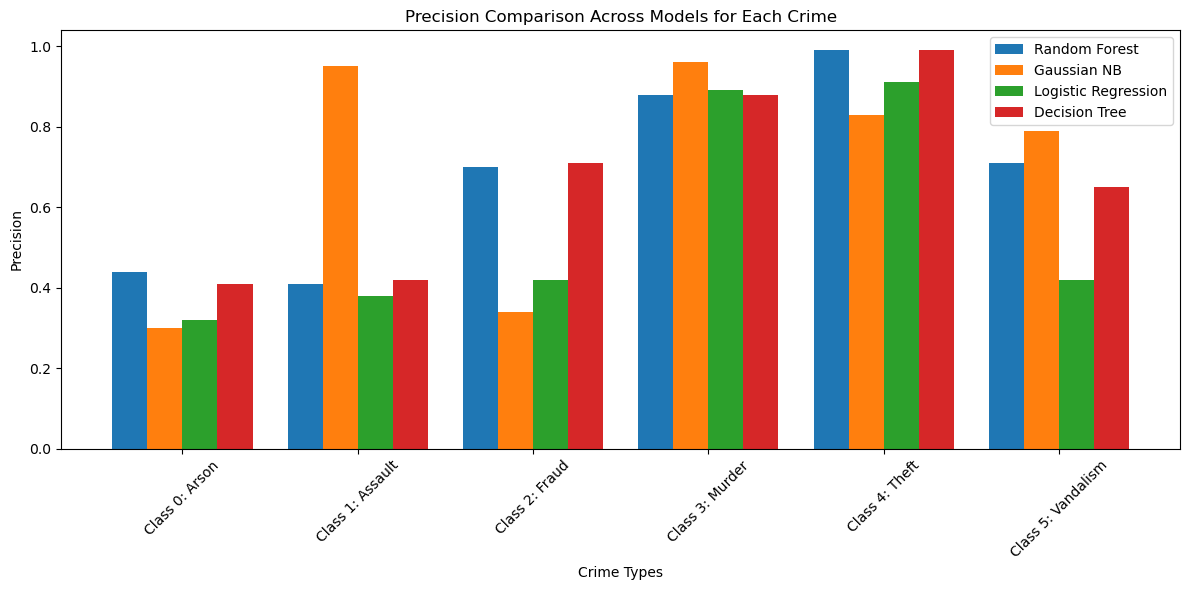

In [55]:
plot_grouped_bar(precision_values, 'Precision', 'Precision', 'Precision Comparison Across Models for Each Crime')

# Recall Comparison

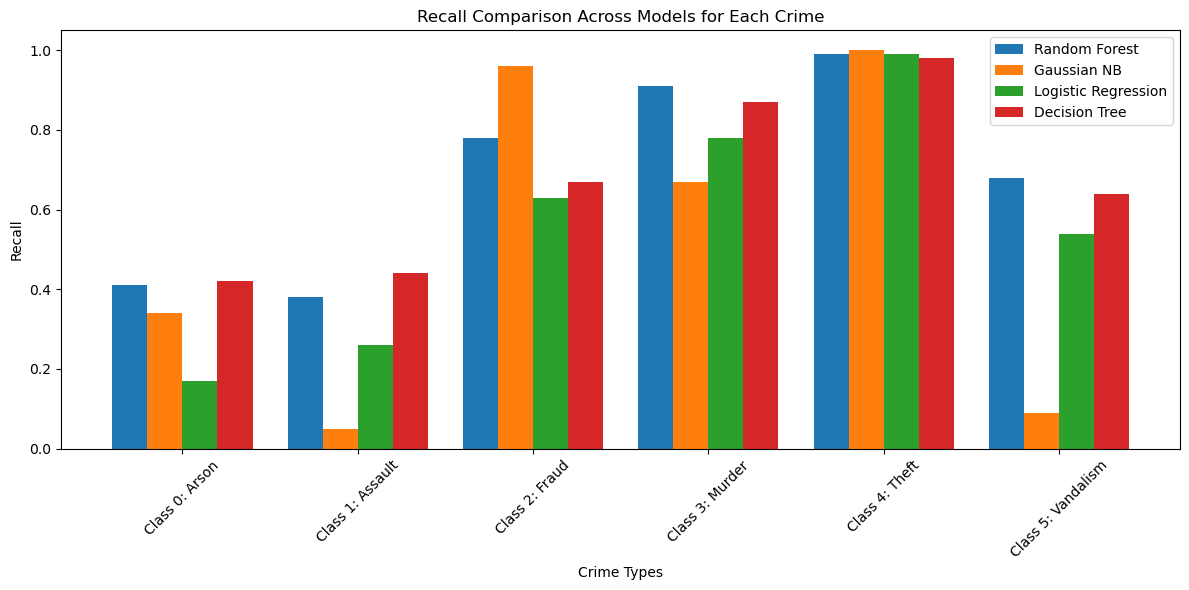

In [56]:
plot_grouped_bar(recall_values, 'Recall', 'Recall', 'Recall Comparison Across Models for Each Crime')

# F1-Score Comparison

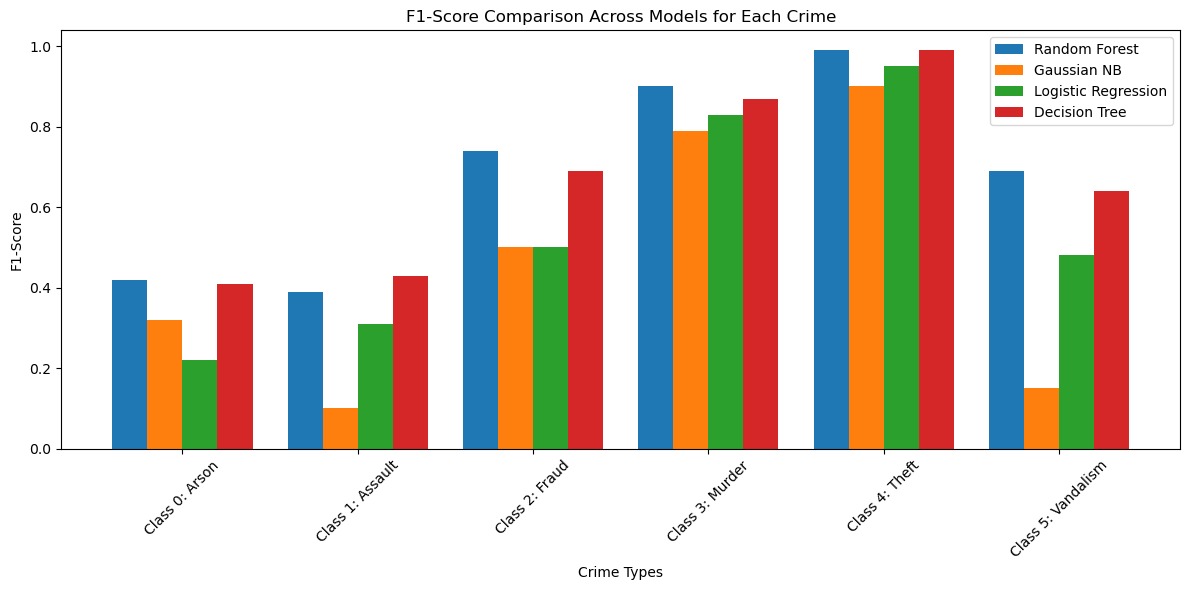

In [57]:
plot_grouped_bar(f1_values, 'F1-Score', 'F1-Score', 'F1-Score Comparison Across Models for Each Crime')

# Accuracy Comparison: With vs Without Stratified K-Fold

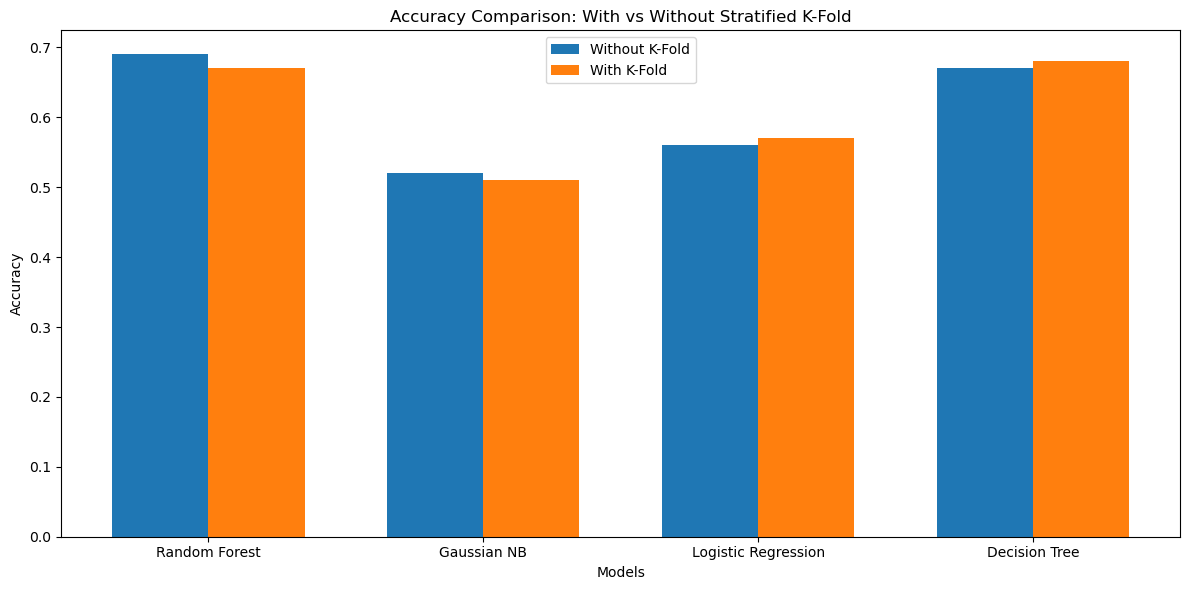

In [58]:
# Model names
models = ['Random Forest', 'Gaussian NB', 'Logistic Regression', 'Decision Tree']

# Accuracy values with and without Stratified K-Fold
accuracy_values = {
    "Without K-Fold": [0.69, 0.52, 0.56, 0.67],
    "With K-Fold": [0.67, 0.51, 0.57, 0.68]
}

# ROC AUC values with and without Stratified K-Fold
roc_auc_values = {
    "Without K-Fold": [0.83, 0.83, 0.85, 0.80],
    "With K-Fold": [0.83, 0.83, 0.85, 0.81]
}

# Precision, Recall, F1-Score for Random Forest (With K-Fold)
rf_metrics = {'Precision': 0.67, 'Recall': 0.67, 'F1-Score': 0.67}

# Plot grouped bar chart for Accuracy comparison
x = np.arange(len(models))  # X-axis positions
width = 0.35  # Bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, accuracy_values["Without K-Fold"], width=width, label="Without K-Fold")
plt.bar(x + width / 2, accuracy_values["With K-Fold"], width=width, label="With K-Fold")

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: With vs Without Stratified K-Fold")
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()